#Libraries

In [ ]:

import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import sklearn.metrics as metrics
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")
import math as ma

#Import Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Loan_prediction/train_ctrUa4K.csv')
test = pd.read_csv('/content/drive/MyDrive/Loan_prediction/test_lAUu6dG.csv')



```
# Tiene formato de código
```

#Exploring training dataset

In [ ]:
train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [ ]:
#Dataset report
def column_report(train):
    a = pd.DataFrame(train.dtypes, columns=['dtype'])
    b = pd.DataFrame(train.isna().sum(), columns=['nulls'])
    b['%nulls'] = round(100 * b['nulls'] / train.shape[0], 2)
    c = train.describe(include='all').transpose()
    return a.join(b).join(c).sort_values(by=['dtype', 'nulls'])

report = column_report(train)
pd.set_option('display.max_rows', 1000)
report

,dtype,nulls,%nulls,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ApplicantIncome,int64,0,0.00,614.0,NaN,NaN,NaN,5403.459283,6109.041673,150.0,2877.5,3812.5,5795.0,81000.0
CoapplicantIncome,float64,0,0.00,614.0,NaN,NaN,NaN,1621.245798,2926.248369,0.0,0.0,1188.5,2297.25,41667.0
Loan_Amount_Term,float64,14,2.28,600.0,NaN,NaN,NaN,342.0,65.12041,12.0,360.0,360.0,360.0,480.0
LoanAmount,float64,22,3.58,592.0,NaN,NaN,NaN,146.412162,85.587325,9.0,100.0,128.0,168.0,700.0
Credit_History,float64,50,8.14,564.0,NaN,NaN,NaN,0.842199,0.364878,0.0,1.0,1.0,1.0,1.0
Loan_ID,object,0,0.00,614,614,LP001002,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Education,object,0,0.00,614,2,Graduate,480,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Property_Area,object,0,0.00,614,3,Semiurban,233,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Loan_Status,object,0,0.00,614,2,Y,422,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Married,object,3,0.49,611,2,Yes,398,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#We look for duplicates
train[train.duplicated(keep = False)]

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status


In [ ]:
# Calculate Loan Approval Rate
approval_rate = train['Loan_Status'].value_counts(normalize=True)['Y']
print("Loan approval rate:", approval_rate)

Tasa de aprobación de préstamos: 0.6872964169381107


Loan approval rate is 68%.

#Exploring test dataset

In [ ]:
test.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,NaN,Urban
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban


In [ ]:
test.shape

(367, 12)

In [ ]:
#Dataset report
def column_report(test):
    a = pd.DataFrame(test.dtypes, columns=['dtype'])
    b = pd.DataFrame(test.isna().sum(), columns=['nulls'])
    b['%nulls'] = round(100 * b['nulls'] / test.shape[0], 2)
    c = test.describe(include='all').transpose()
    return a.join(b).join(c).sort_values(by=['dtype', 'nulls'])

report_1 = column_report(train)
pd.set_option('display.max_rows', 1000)
report_1

,dtype,nulls,%nulls,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ApplicantIncome,int64,0,0.00,614.0,NaN,NaN,NaN,5403.459283,6109.041673,150.0,2877.5,3812.5,5795.0,81000.0
CoapplicantIncome,float64,0,0.00,614.0,NaN,NaN,NaN,1621.245798,2926.248369,0.0,0.0,1188.5,2297.25,41667.0
Loan_Amount_Term,float64,14,2.28,600.0,NaN,NaN,NaN,342.0,65.12041,12.0,360.0,360.0,360.0,480.0
LoanAmount,float64,22,3.58,592.0,NaN,NaN,NaN,146.412162,85.587325,9.0,100.0,128.0,168.0,700.0
Credit_History,float64,50,8.14,564.0,NaN,NaN,NaN,0.842199,0.364878,0.0,1.0,1.0,1.0,1.0
Loan_ID,object,0,0.00,614,614,LP001002,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Education,object,0,0.00,614,2,Graduate,480,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Property_Area,object,0,0.00,614,3,Semiurban,233,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Loan_Status,object,0,0.00,614,2,Y,422,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Married,object,3,0.49,611,2,Yes,398,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#We look for duplicates
test[test.duplicated(keep = False)]

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area


#Nulls treatment


train

In [ ]:
train.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

Numerical values

In [ ]:
train['LoanAmount'] = train['LoanAmount'].fillna(train['LoanAmount'].mean())
train['Loan_Amount_Term'] = train['Loan_Amount_Term'].fillna(train['Loan_Amount_Term'].mean())

Categorical values


In [ ]:
train['Gender'] = train['Gender'].fillna(train['Gender'].mode()[0])
train['Married'] = train['Married'].fillna(train['Married'].mode()[0])
train['Dependents'] = train['Dependents'].fillna(train['Dependents'].mode()[0])
train['Self_Employed'] = train['Self_Employed'].fillna(train['Self_Employed'].mode()[0])
train['Credit_History'] = train['Credit_History'].fillna(train['Credit_History'].mode()[0])

In [ ]:
# Reemplazar '3+' por '3' en la columna 'Dependents'
train['Dependents'] = train['Dependents'].replace('3+', '3')

# Verificar los cambios
print(train['Dependents'].unique())  # Mostrar los valores únicos después del reemplazo

['0' '1' '2' '3']


test

In [ ]:
test.isnull().sum()

Loan_ID               0
Gender               11
Married               0
Dependents           10
Education             0
Self_Employed        23
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            5
Loan_Amount_Term      6
Credit_History       29
Property_Area         0
dtype: int64

Numerical values

In [ ]:
test['LoanAmount'] = test['LoanAmount'].fillna(train['LoanAmount'].mean())
test['Loan_Amount_Term'] = test['Loan_Amount_Term'].fillna(train['Loan_Amount_Term'].mean())

Categorical values

In [ ]:
test['Gender'] = test['Gender'].fillna(train['Gender'].mode()[0])
test['Dependents'] = test['Dependents'].fillna(train['Dependents'].mode()[0])
test['Self_Employed'] = test['Self_Employed'].fillna(train['Self_Employed'].mode()[0])
test['Credit_History'] = test['Credit_History'].fillna(train['Credit_History'].mode()[0])

In [ ]:
# Replace '3+' with '3' in 'Dependents' column
test['Dependents'] = test['Dependents'].replace('3+', '3')

# Verify changes
print(test['Dependents'].unique())  # Mostrar los valores únicos después del reemplazo

['0' '1' '2' '3']


In [ ]:
train.isnull().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

In [ ]:
test.isnull().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
dtype: int64

#New variables

In [ ]:
train['Total_Income'] = train['ApplicantIncome'] + train['CoapplicantIncome']
train.head()


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Total_Income
0,LP001002,Male,No,0,Graduate,No,5849,0.0,146.412162,360.0,1.0,Urban,Y,5849.0
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.000000,360.0,1.0,Rural,N,6091.0
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.000000,360.0,1.0,Urban,Y,3000.0
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.000000,360.0,1.0,Urban,Y,4941.0
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.000000,360.0,1.0,Urban,Y,6000.0


In [ ]:
test['Total_Income'] = test['ApplicantIncome'] + test['CoapplicantIncome']
test.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Total_Income
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban,5720
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban,4576
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban,6800
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,1.0,Urban,4886
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban,3276


#EDA

Categorical values

<Axes: xlabel='count', ylabel='Gender'>

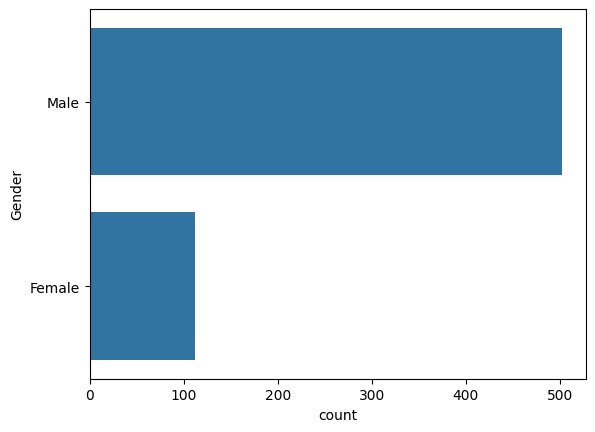

In [ ]:
sns.countplot(train['Gender'])

<Axes: xlabel='count', ylabel='Married'>

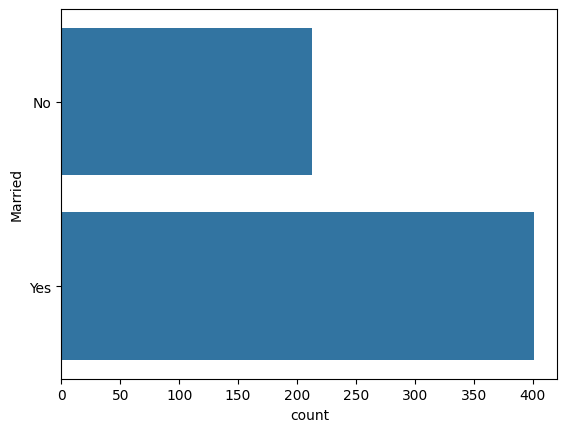

In [ ]:
sns.countplot(train['Married'])

<Axes: xlabel='count', ylabel='Dependents'>

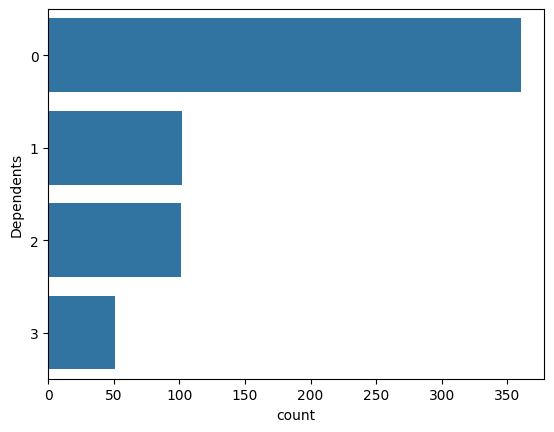

In [ ]:
sns.countplot(train['Dependents'])

<Axes: xlabel='count', ylabel='Education'>

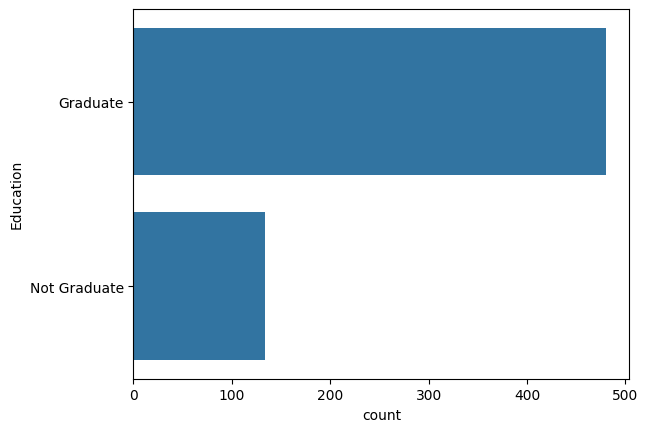

In [ ]:
sns.countplot(train['Education'])

<Axes: xlabel='count', ylabel='Self_Employed'>

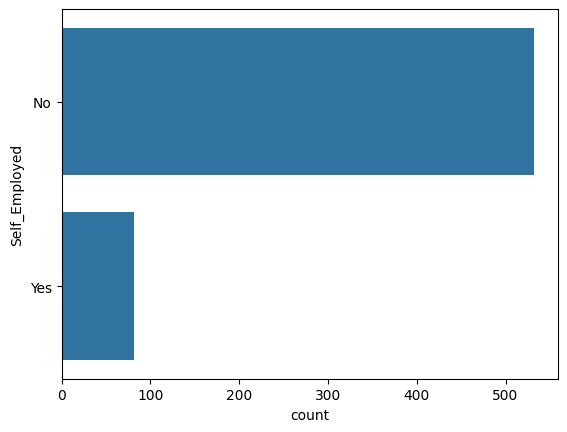

In [ ]:
sns.countplot(train['Self_Employed'])

<Axes: xlabel='count', ylabel='Property_Area'>

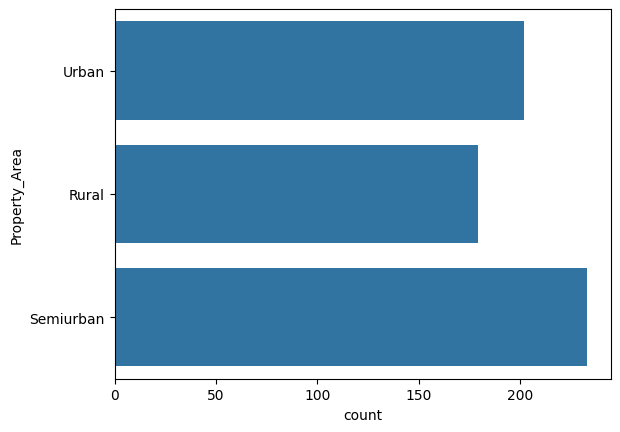

In [ ]:
sns.countplot(train['Property_Area'])

<Axes: xlabel='count', ylabel='Loan_Status'>

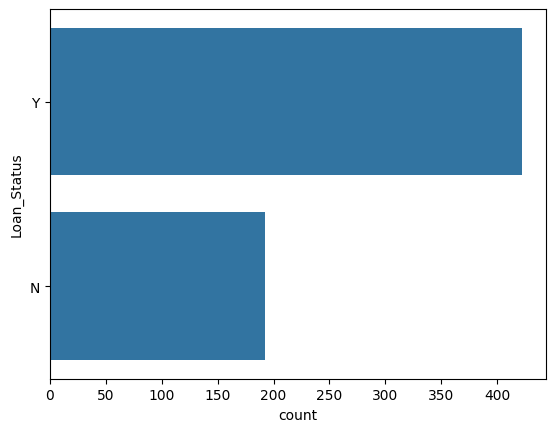

In [ ]:
sns.countplot(train['Loan_Status'])

Numerical values

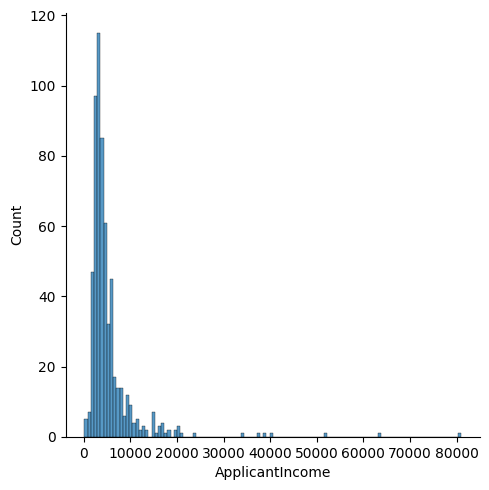

In [ ]:
sns.displot(train['ApplicantIncome'])

We apply log to balance

In [ ]:
train['ApplicantIncome_Log'] = np.log(train['ApplicantIncome'])

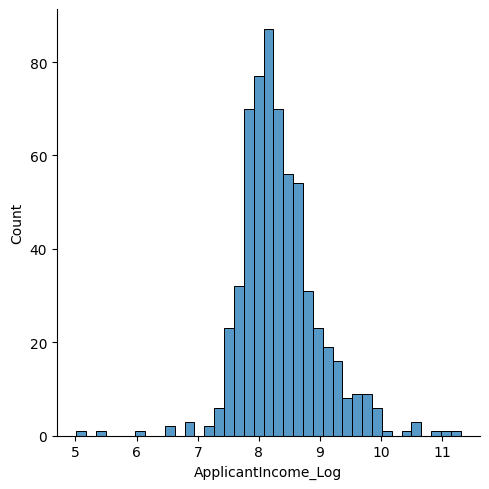

In [ ]:
sns.displot(train['ApplicantIncome_Log'])

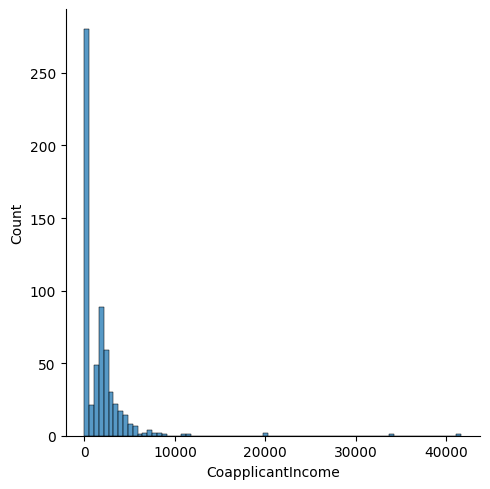

In [ ]:
sns.displot(train['CoapplicantIncome'])

In [ ]:
train['CoapplicantIncome_Log'] = np.log(train['CoapplicantIncome'])

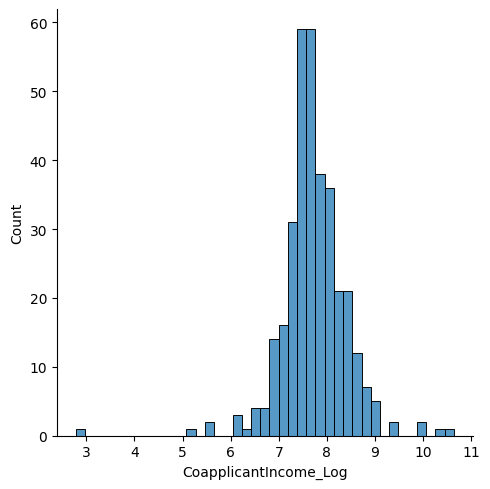

In [ ]:
sns.displot(train['CoapplicantIncome_Log'])

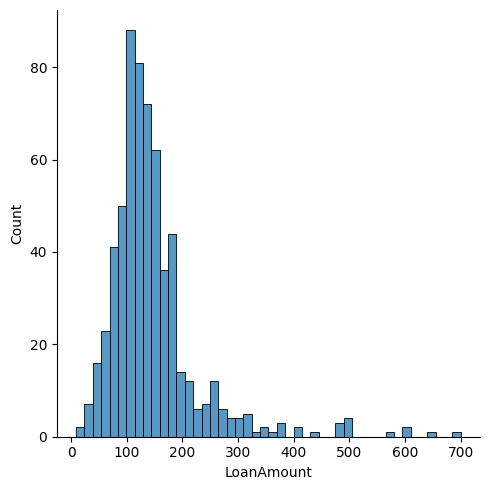

In [ ]:
sns.displot(train['LoanAmount'])

In [ ]:
train['LoanAmount_Log'] = np.log(train['LoanAmount'])

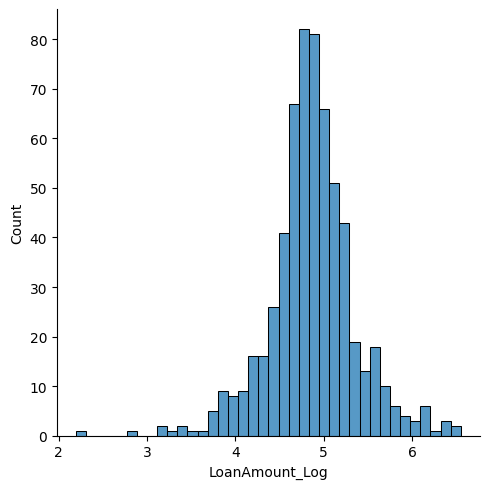

In [ ]:
sns.displot(train['LoanAmount_Log'])

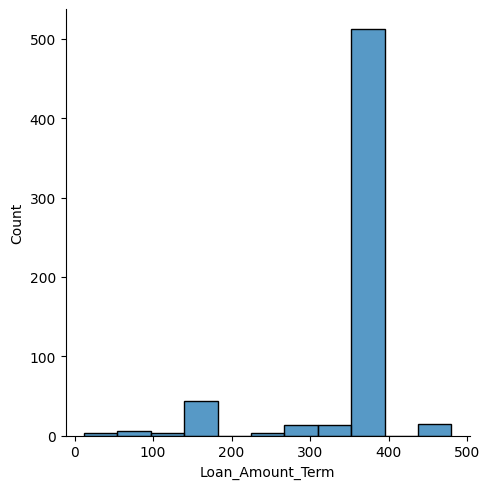

In [ ]:
sns.displot(train['Loan_Amount_Term'])

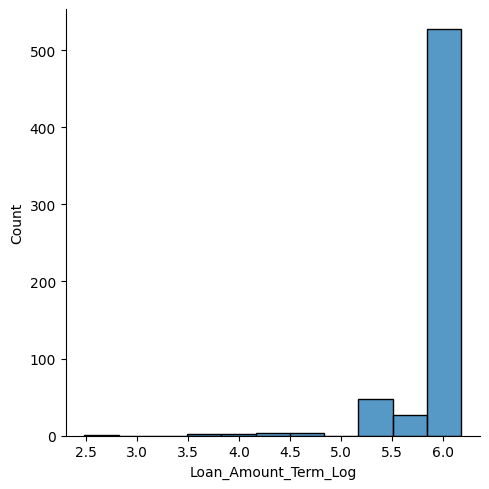

In [ ]:
train['Loan_Amount_Term_Log'] = np.log(train['Loan_Amount_Term'])
sns.displot(train['Loan_Amount_Term_Log'])

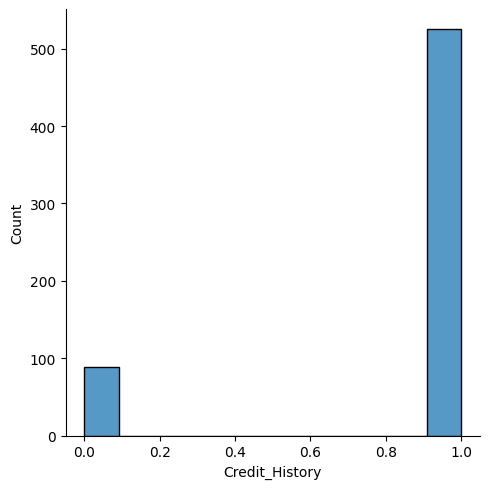

In [ ]:
sns.displot(train['Credit_History'])

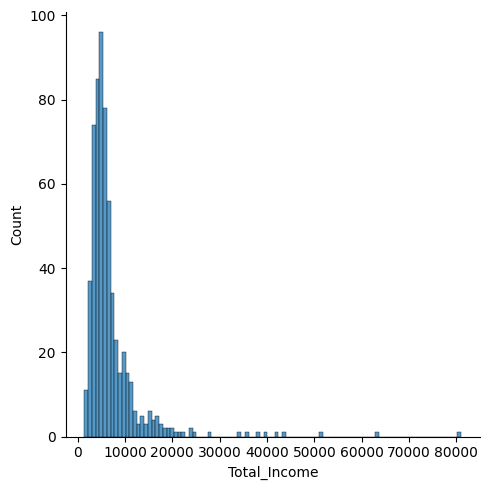

In [ ]:
sns.displot(train['Total_Income'])

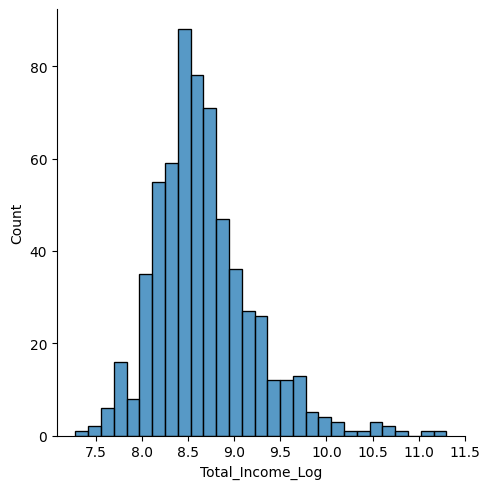

In [ ]:
train['Total_Income_Log'] = np.log(train['Total_Income'])
sns.displot(train['Total_Income_Log'])

Dataset test variables

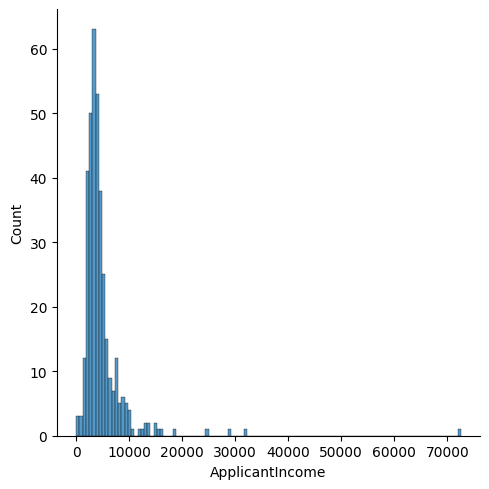

In [ ]:
sns.displot(test['ApplicantIncome'])


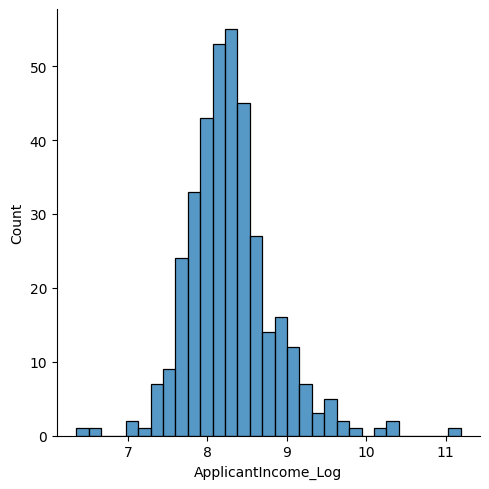

In [ ]:
test['ApplicantIncome_Log'] = np.log(test['ApplicantIncome'])
sns.displot(test['ApplicantIncome_Log'])


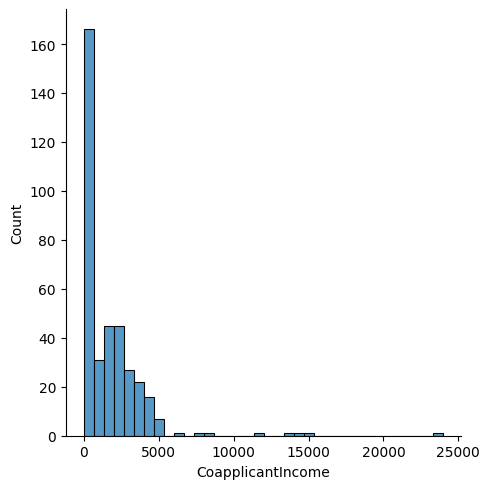

In [ ]:
sns.displot(test['CoapplicantIncome'])

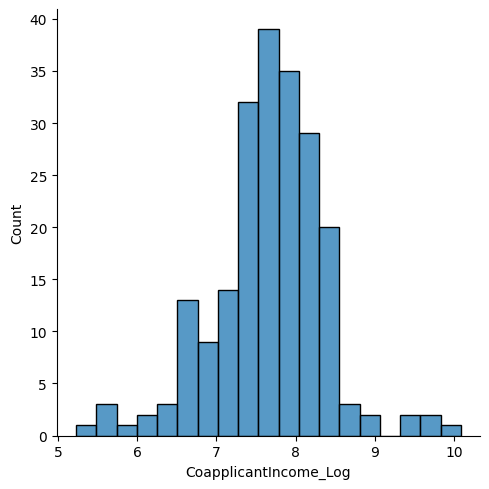

In [ ]:
test['CoapplicantIncome_Log'] = np.log(test['CoapplicantIncome'])
sns.displot(test['CoapplicantIncome_Log'])

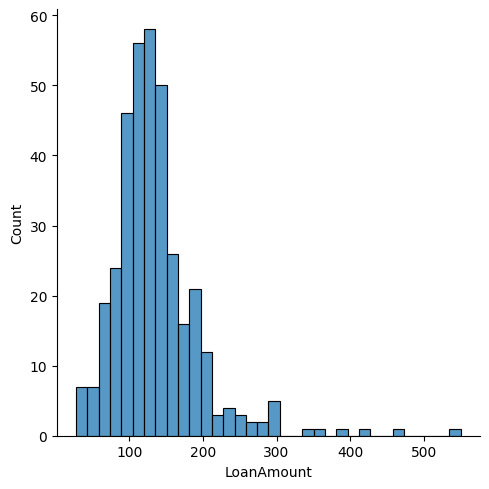

In [ ]:
sns.displot(test['LoanAmount'])

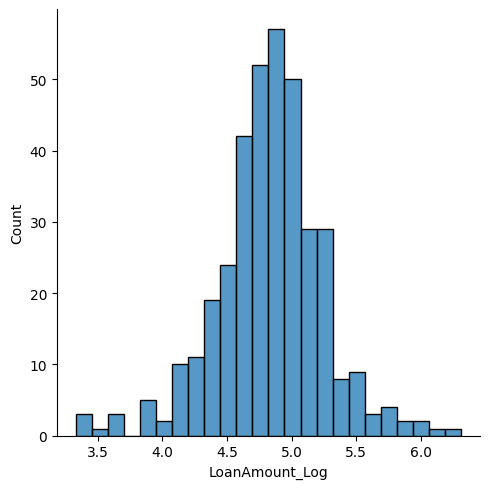

In [ ]:
test['LoanAmount_Log'] = np.log(test['LoanAmount'])
sns.displot(test['LoanAmount_Log'])

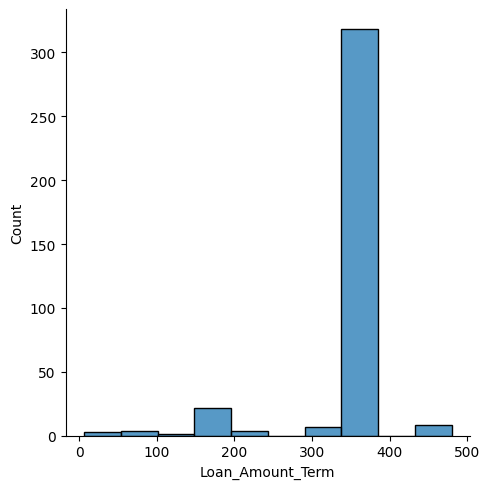

In [ ]:
sns.displot(test['Loan_Amount_Term'])

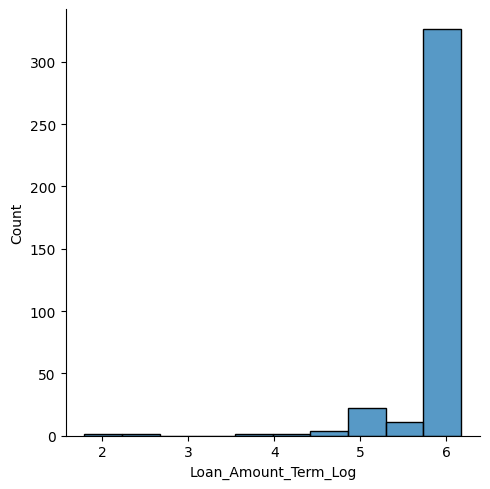

In [ ]:
test['Loan_Amount_Term_Log'] = np.log(test['Loan_Amount_Term'])
sns.displot(test['Loan_Amount_Term_Log'])


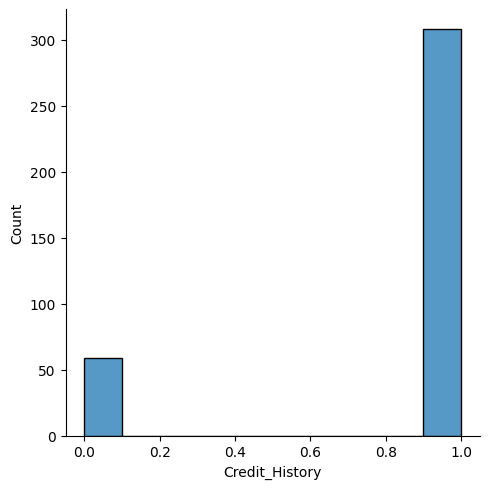

In [ ]:
sns.displot(test['Credit_History'])

I replace the modified columns with log

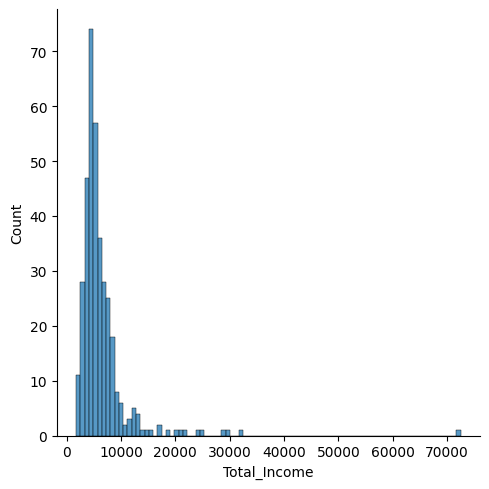

In [ ]:
sns.displot(test['Total_Income'])


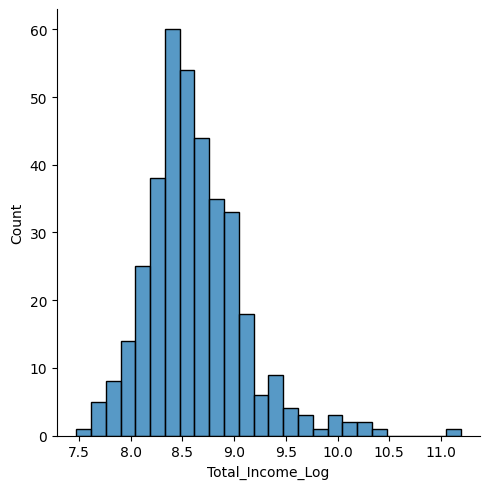

In [ ]:
test['Total_Income_Log'] = np.log(test['Total_Income'])
sns.displot(test['Total_Income_Log'])

In [ ]:
train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Total_Income,ApplicantIncome_Log,CoapplicantIncome_Log,LoanAmount_Log,Loan_Amount_Term_Log,Total_Income_Log
0,LP001002,Male,No,0,Graduate,No,5849,0.0,146.412162,360.0,1.0,Urban,Y,5849.0,8.674026,-inf,4.986426,5.886104,8.674026
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.000000,360.0,1.0,Rural,N,6091.0,8.430109,7.318540,4.852030,5.886104,8.714568
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.000000,360.0,1.0,Urban,Y,3000.0,8.006368,-inf,4.189655,5.886104,8.006368
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.000000,360.0,1.0,Urban,Y,4941.0,7.856707,7.765569,4.787492,5.886104,8.505323
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.000000,360.0,1.0,Urban,Y,6000.0,8.699515,-inf,4.948760,5.886104,8.699515


In [ ]:
train.drop(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Total_Income'], axis=1, inplace=True)

In [ ]:
test.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Total_Income,ApplicantIncome_Log,CoapplicantIncome_Log,LoanAmount_Log,Loan_Amount_Term_Log,Total_Income_Log
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban,5720,8.651724,-inf,4.700480,5.886104,8.651724
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban,4576,8.031385,7.313220,4.836282,5.886104,8.428581
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban,6800,8.517193,7.495542,5.337538,5.886104,8.824678
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,1.0,Urban,4886,7.757906,7.842279,4.605170,5.886104,8.494129
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban,3276,8.094378,-inf,4.356709,5.886104,8.094378


In [ ]:
test.drop(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Total_Income'], axis=1, inplace=True)

#Correlation of variables

In [ ]:
#I save the loan_id column
train_loan_id = train['Loan_ID']

In [ ]:
test_loan_id = test['Loan_ID']

In [ ]:
del test['Loan_ID']

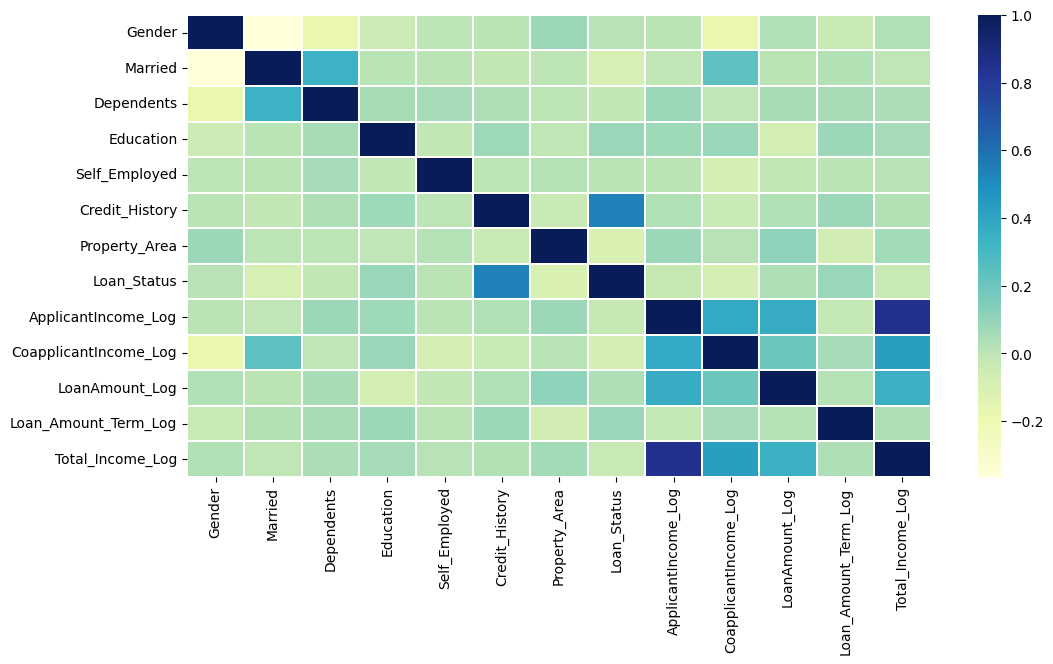

In [ ]:
plt.figure(figsize=(12, 6))
train.drop(['Loan_ID'], axis=1, inplace=True)  # Comentario correcto, pero la línea estaba comentada de forma incorrecta
corr = train.apply(lambda x: pd.factorize(x)[0]).corr()
ax = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns,
                 linewidths=.2, cmap="YlGnBu")

In [ ]:
train.head()

,Gender,Married,Dependents,Education,Self_Employed,Credit_History,Property_Area,Loan_Status,ApplicantIncome_Log,CoapplicantIncome_Log,LoanAmount_Log,Loan_Amount_Term_Log,Total_Income_Log
0,Male,No,0,Graduate,No,1.0,Urban,Y,8.674026,-inf,4.986426,5.886104,8.674026
1,Male,Yes,1,Graduate,No,1.0,Rural,N,8.430109,7.318540,4.852030,5.886104,8.714568
2,Male,Yes,0,Graduate,Yes,1.0,Urban,Y,8.006368,-inf,4.189655,5.886104,8.006368
3,Male,Yes,0,Not Graduate,No,1.0,Urban,Y,7.856707,7.765569,4.787492,5.886104,8.505323
4,Male,No,0,Graduate,No,1.0,Urban,Y,8.699515,-inf,4.948760,5.886104,8.699515


In [ ]:
test.head()

,Gender,Married,Dependents,Education,Self_Employed,Credit_History,Property_Area,ApplicantIncome_Log,CoapplicantIncome_Log,LoanAmount_Log,Loan_Amount_Term_Log,Total_Income_Log
0,Male,Yes,0,Graduate,No,1.0,Urban,8.651724,-inf,4.700480,5.886104,8.651724
1,Male,Yes,1,Graduate,No,1.0,Urban,8.031385,7.313220,4.836282,5.886104,8.428581
2,Male,Yes,2,Graduate,No,1.0,Urban,8.517193,7.495542,5.337538,5.886104,8.824678
3,Male,Yes,2,Graduate,No,1.0,Urban,7.757906,7.842279,4.605170,5.886104,8.494129
4,Male,No,0,Not Graduate,No,1.0,Urban,8.094378,-inf,4.356709,5.886104,8.094378


Eliminaremos a la columna 'CoapplicantIncome' ya que tiene algunos valores con '-inf'.

In [ ]:
train.drop(['CoapplicantIncome_Log'], axis=1, inplace=True)

In [ ]:
test.drop(['CoapplicantIncome_Log'], axis=1, inplace=True)

#Label Encoding

In [ ]:
from sklearn.preprocessing import LabelEncoder
cols = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Credit_History', 'Property_Area']
le = LabelEncoder()
for col in cols:
  train[col] = le.fit_transform(train[col])

In [ ]:
train.head()

,Gender,Married,Dependents,Education,Self_Employed,Credit_History,Property_Area,Loan_Status,ApplicantIncome_Log,LoanAmount_Log,Loan_Amount_Term_Log,Total_Income_Log
0,1,0,0,0,0,1,2,Y,8.674026,4.986426,5.886104,8.674026
1,1,1,1,0,0,1,0,N,8.430109,4.852030,5.886104,8.714568
2,1,1,0,0,1,1,2,Y,8.006368,4.189655,5.886104,8.006368
3,1,1,0,1,0,1,2,Y,7.856707,4.787492,5.886104,8.505323
4,1,0,0,0,0,1,2,Y,8.699515,4.948760,5.886104,8.699515


In [ ]:
from sklearn.preprocessing import LabelEncoder
cols = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Credit_History', 'Property_Area']
le = LabelEncoder()
for col in cols:
  test[col] = le.fit_transform(test[col])

In [ ]:
test.head()

,Gender,Married,Dependents,Education,Self_Employed,Credit_History,Property_Area,ApplicantIncome_Log,LoanAmount_Log,Loan_Amount_Term_Log,Total_Income_Log
0,1,1,0,0,0,1,2,8.651724,4.700480,5.886104,8.651724
1,1,1,1,0,0,1,2,8.031385,4.836282,5.886104,8.428581
2,1,1,2,0,0,1,2,8.517193,5.337538,5.886104,8.824678
3,1,1,2,0,0,1,2,7.757906,4.605170,5.886104,8.494129
4,1,0,0,1,0,1,2,8.094378,4.356709,5.886104,8.094378


In [ ]:
variables_inf = test.columns[(test == -np.inf).any()]
variables_inf

Index(['ApplicantIncome_Log'], dtype='object')

In [ ]:
num_inf_values = (test == -np.inf).sum()
num_inf_values

Gender                  0
Married                 0
Dependents              0
Education               0
Self_Employed           0
Credit_History          0
Property_Area           0
ApplicantIncome_Log     2
LoanAmount_Log          0
Loan_Amount_Term_Log    0
Total_Income_Log        0
dtype: int64

In [ ]:
test.replace(-np.inf, 0, inplace=True)

#Train Split Test

In [ ]:
#Specify input and output
X = train.drop(columns=['Loan_Status'], axis=1)
y = train['Loan_Status']

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

#Model training

In [ ]:
from sklearn.model_selection import cross_val_score
def classify(model, X, y):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
  model.fit(X_train, y_train)
  print('Accuracy: ', model.score(X_test, y_test)*100)
  score = cross_val_score(model, X, y, cv=5)
  print('Cross validation: ', np.mean(score)*100)

In [ ]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
classify(model, X, y)

Accuracy:  77.27272727272727
Cross validation:  80.9462881514061


In [ ]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
classify(model, X, y)

Accuracy:  70.77922077922078
Cross validation:  72.47900839664135


In [ ]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
model = RandomForestClassifier()
classify(model, X, y)

Accuracy:  76.62337662337663
Cross validation:  77.52632280421165


In [ ]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
model = ExtraTreesClassifier()
classify(model, X, y)

Accuracy:  75.97402597402598
Cross validation:  76.22151139544182


#Hyperparameter Tunning


In [ ]:
model = RandomForestClassifier(n_estimators=100, min_samples_split=25, max_depth=7, max_features=1)
classify(model, X, y)

Accuracy:  77.27272727272727
Cross validation:  80.45715047314408


#Confusion matrix

In [ ]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm

array([[23, 31],
       [ 4, 96]])

#Prediction

In [ ]:
# Initialize the RandomForestClassifier model
model = RandomForestClassifier(n_estimators=100, min_samples_split=25, max_depth=7, max_features=1)

# Train the model with training data (X_train, y_train)
model.fit(X_train, y_train)

# Make predictions on the test data set
predictions = model.predict(test)
predictions

array(['Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'Y',
       'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'N',
       'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'Y',
       'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y',
       'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'Y',
       'Y', 'N', 'N', 'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y',
       'Y', 'Y', 'N', 'Y', 'N', 'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y',
       'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'Y',
       'Y', 'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y',
       'N', 'N', 'N', 'Y', 'Y', 'Y', 'N', 'N', 'Y', 'N', 'Y', 'Y', 'Y',
       'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'N',
       'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'Y',
       'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'Y', 'N', 'N', 'Y', 'Y',
       'Y', 'Y', 'Y', 'Y', 'N', 'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y

In [ ]:
# create a dataframe with my prediction and the probabilities
df_prediccion = pd.DataFrame()
df_prediccion['Loan_ID'] = test_loan_id
df_prediccion['Loan_Status'] = predictions
df_prediccion

,Loan_ID,Loan_Status
0,LP001015,Y
1,LP001022,Y
2,LP001031,Y
3,LP001035,Y
4,LP001051,Y
5,LP001054,Y
6,LP001055,Y
7,LP001056,N
8,LP001059,Y
9,LP001067,Y


In [ ]:
# Filter rows with 'N' in loan_status
status_N = df_prediccion[df_prediccion['Loan_Status'] == 'N']

# Filter rows with 'Y' in loan_status
status_Y = df_prediccion[df_prediccion['Loan_Status'] == 'Y']

# Calculate the average of rows with 'N' and 'Y'
promedio_N = status_N.shape[0] / df_prediccion.shape[0]
promedio_Y = status_Y.shape[0] / df_prediccion.shape[0]

# Print the results
print("Promedio de filas con 'N':", promedio_N)
print("Promedio de filas con 'Y':", promedio_Y)

Promedio de filas con 'N': 0.14168937329700274
Promedio de filas con 'Y': 0.8583106267029973


In [ ]:
df_prediccion.to_csv('df_prediccion.csv', index=False)

In [ ]:
! cat df_prediccion.csv

Loan_ID,Loan_Status
LP001015,Y
LP001022,Y
LP001031,Y
LP001035,Y
LP001051,Y
LP001054,Y
LP001055,Y
LP001056,N
LP001059,Y
LP001067,Y
LP001078,Y
LP001082,Y
LP001083,Y
LP001094,Y
LP001096,Y
LP001099,Y
LP001105,Y
LP001107,Y
LP001108,Y
LP001115,Y
LP001121,Y
LP001124,Y
LP001128,Y
LP001135,Y
LP001149,Y
LP001153,N
LP001163,Y
LP001169,Y
LP001174,Y
LP001176,Y
LP001177,Y
LP001183,Y
LP001185,Y
LP001187,Y
LP001190,Y
LP001203,N
LP001208,Y
LP001210,Y
LP001211,Y
LP001219,Y
LP001220,Y
LP001221,Y
LP001226,Y
LP001230,Y
LP001231,Y
LP001232,Y
LP001237,Y
LP001242,Y
LP001268,Y
LP001270,Y
LP001284,Y
LP001287,Y
LP001291,Y
LP001298,Y
LP001312,Y
LP001313,N
LP001317,Y
LP001321,Y
LP001323,Y
LP001324,Y
LP001332,Y
LP001335,Y
LP001338,Y
LP001347,N
LP001348,Y
LP001351,Y
LP001352,N
LP001358,N
LP001359,Y
LP001361,N
LP001366,Y
LP001368,Y
LP001375,Y
LP001380,Y
LP001386,Y
LP001400,Y
LP001407,Y
LP001413,Y
LP001415,Y
LP001419,Y
LP001420,N
LP001428,Y
LP001445,N
LP001446,Y
LP001450,N
LP001452,Y
LP001455,Y
LP001466,Y
LP001471,Y
L